<a href="https://colab.research.google.com/github/Asma-Ahmed-Aqil-AL-Zubaidi/Sentiment-Analysis-with-RNN-LSTM-GRU-IMDB/blob/main/DL3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 17.6 MB/s eta 0:00:00


In [ ]:
import random
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.datasets import imdb
import pandas as pd
import matplotlib.pyplot as plt
import re
import emoji
from tqdm import tqdm
from sklearn.metrics import classification_report
import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LeakyReLU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import  GRU
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import optuna
from tensorflow.keras.optimizers import Adam


SEED = 42

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])


train_reviews = [decode_review(x) for x in x_train]
test_reviews = [decode_review(x) for x in x_test]


df = pd.DataFrame({
    "review": train_reviews + test_reviews,
    "label": list(y_train) + list(y_test)
})


df.head()

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


,review,label
0,? this film was just brilliant casting locatio...,1
1,? big hair big boobs bad music and a giant saf...,0
2,? this has to be one of the worst films of the...,0
3,? the ? ? at storytelling the traditional sort...,1
4,? worst mistake of my life br br i picked this...,0


# 1-Text EDA

In [ ]:
df.head()

,review,label
0,? this film was just brilliant casting locatio...,1
1,? big hair big boobs bad music and a giant saf...,0
2,? this has to be one of the worst films of the...,0
3,? the ? ? at storytelling the traditional sort...,1
4,? worst mistake of my life br br i picked this...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  50000 non-null  object
 1   label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [ ]:
df['label'].value_counts()

,count
label,
1,25000
0,25000


In [ ]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
df['review_length'].describe()

,review_length
count,50000.000000
mean,234.755400
std,172.907439
min,7.000000
25%,129.000000
50%,176.000000
75%,285.000000
max,2494.000000


In [ ]:
df.isnull().sum()

,0
review,0
label,0
review_length,0


In [ ]:
df.sample(3)['review'].values

array(["? everyone should totally see this movie it's freaking scary but doesn't resort to lame jump out at you just to surprise you and pass it off as scary things it really is great see this freaking awesome movie the director is stanley kubrick easily the greatest director who ever lived every single one of his movies are masterpieces including this one the shining is about this family that goes to a hotel in the ? ? as ? for the winters and get ? in well the house is haunted the kid is psychic the husband is easily ? by evil haunted ? and well hilarity ensues not really it becomes this gripping thriller where stuff gets thrown at the viewer from all different directions and it gets scary not just the classic here's johnny scene it's memorable but can't speak for the whole movies it's one of those things where words don't explain it adequately and you just gotta see it so go on netflix and get it ? ?",
       "? the prey has an interesting history unless you remember the ads for it 

In [ ]:
df.shape

(50000, 3)

In [ ]:
df.columns

Index(['review', 'label', 'review_length'], dtype='object')

In [ ]:
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}


def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])


train_reviews = [decode_review(x) for x in x_train]
test_reviews = [decode_review(x) for x in x_test]


df = pd.DataFrame({
    "review": train_reviews + test_reviews,
    "label": list(y_train) + list(y_test)
})


label_map = {0: "Negative", 1: "Positive"}
df['label_name'] = df['label'].map(label_map)
sentiment_counts = df['label_name'].value_counts()

print(" Sentiment Distribution:")
print(sentiment_counts)


df['review_length'] = df['review'].apply(lambda x: len(x.split()))
length_stats = df['review_length'].describe()

print("\n Review Length Statistics (in words):")
print(length_stats)

 Sentiment Distribution:
label_name
Positive    25000
Negative    25000
Name: count, dtype: int64

 Review Length Statistics (in words):
count    50000.000000
mean       234.755400
std        172.907439
min          7.000000
25%        129.000000
50%        176.000000
75%        285.000000
max       2494.000000
Name: review_length, dtype: float64


# Best Practice to remove the text les then 10

In [ ]:
df = df[df['review_length'] >= 10]

In [ ]:
df.shape

(49997, 4)

# 2-Text Preprocessing

# cleaning

In [ ]:
url_pattern = re.compile(r"http\S+|www\S+|https\S+")
mention_pattern = re.compile(r'@\w+')
hashtag_pattern = re.compile(r'#\w+')
brackets_pattern = re.compile(r'[\(\[\{\<][^()\[\]\{\}<>]*[\)\]\}\>]')
html_pattern = re.compile(r'<.*?>')
special_chars_pattern = re.compile(r'[^a-zA-Z\s]')
digits_pattern = re.compile(r'\d+')
repetition_pattern = re.compile(r'(.)\1{2,}', re.DOTALL)
whitespace_pattern = re.compile(r'\s+')

emoji_word_map = {
    "smiling_face_with_heart_eyes": "love",
    "face_with_tears_of_joy": "funny",
    "red_heart": "love",
    "crying_face": "sad",
    "face_with_symbols_on_mouth": "angry",
    "fire": "hot",
    "clapping_hands": "applause",
    "thumbs_up": "approve",
    "thumbs_down": "disapprove",
    "star_struck": "amazed",
    "grinning_face": "happy",
    "thinking_face": "thinking",
    "broken_heart": "heartbroken",
    "hundred_points": "perfect"
}

def replace_emoji_with_words(text):
    text = emoji.demojize(text, delimiters=(" ", " "))
    for code, word in emoji_word_map.items():
        text = text.replace(code, word)
    return text

def clean_base_text(text):
    text = str(text).lower()
    text = replace_emoji_with_words(text)
    text = url_pattern.sub(' ', text)
    text = mention_pattern.sub(' ', text)
    text = hashtag_pattern.sub(' ', text)
    text = brackets_pattern.sub(' ', text)
    text = html_pattern.sub(' ', text)
    text = special_chars_pattern.sub(' ', text)
    text = digits_pattern.sub(' ', text)
    text = whitespace_pattern.sub(' ', text).strip()
    return text

def remove_excessive_repetition(text):
    return repetition_pattern.sub(r'\1\1', text)

def remove_useless_short_words(text):
    words = text.split()
    return ' '.join(word for word in words if len(word) > 2)

def full_cleaning_pipeline(text):
    text = clean_base_text(text)
    text = remove_excessive_repetition(text)
    text = remove_useless_short_words(text)
    return text

tqdm.pandas()
df['cleaned_text'] = df['review'].progress_apply(full_cleaning_pipeline)


df[['review', 'cleaned_text']].sample(5)


100%|██████████| 49997/49997 [00:50<00:00, 989.66it/s] 


,review,cleaned_text
5480,? i don't know why i keep doing this to myself...,don know why keep doing this myself keep defen...
995,? i think this still is the best routine there...,think this still the best routine there are so...
44278,? i decided to hire out this movie along with ...,decided hire out this movie along with few oth...
44110,? i couldn't believe the eye candy from start ...,couldn believe the eye candy from start finish...
38515,? 8 points for take on probably what really ki...,points for take probably what really kinda may...


# Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()


def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def conservative_lemmatize(text):
    tokens = tokenizer.tokenize(text)
    tagged_tokens = pos_tag(tokens)
    lemmatized_tokens = [
        lemmatizer.lemmatize(token, get_wordnet_pos(tag))
        for token, tag in tagged_tokens
    ]
    return ' '.join(lemmatized_tokens)


tqdm.pandas()
df['lemmatized_text'] = df['cleaned_text'].progress_apply(conservative_lemmatize)
df[['cleaned_text', 'lemmatized_text']].sample(5)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
100%|██████████| 49997/49997 [05:05<00:00, 163.46it/s]


,cleaned_text,lemmatized_text
8512,first this movie seems bad that almost fell th...,first this movie seem bad that almost fell the...
5097,the movie starts off setting where not surpris...,the movie start off set where not surprisingly...
28531,this thriller has many twists and turns had th...,this thriller have many twist and turn have th...
21239,know know plan from outer space the worst movi...,know know plan from out space the bad movie ma...
4209,comments this movie have been deleted twice wh...,comment this movie have be delete twice which ...


# Text Vectorization – Tokenization and Padding

In [ ]:
texts = df['lemmatized_text'].values
labels = df['label'].values


X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_texts)

X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

MAXLEN = 300
X_train_pad = pad_sequences(X_train_seq, maxlen=MAXLEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAXLEN, padding='post', truncating='post')

print(" Vocabulary size:", len(tokenizer.word_index))
print(" X_train shape:", X_train_pad.shape)
print(" X_test shape:", X_test_pad.shape)
print(" Example padded sequence:", X_train_pad[0])

 Vocabulary size: 9179
 X_train shape: (39997, 300)
 X_test shape: (10000, 300)
 Example padded sequence: [   4  120    2    8 1588    3  188 4688   11  776    3    4   48  159
  157  411   41  269  243   56   12 1143    4  358  246   30    2    8
    4 2519 1260    2  370    4 2201  308   93  364    2  374    4   64
  364   83  503 2410    3 3558  104  647  223  112    4  991  120    5
 1080  419   82 1532  232   39   43   12   66   22   67  226  301   84
  194    5    9   19   39 1389    3  735  767   70  246  364    5    9
    7   71   11    2   48  678   78   30    5    8    4    4  450   72
   87  316 2824   13  626   17 1070  302    2  164    6   82   19   11
  191   12   24  140 1326   30   17    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  

____________________________________________________________________________________________________________________________________________________________________


# Build and Train Simple RNN Model



____________________________________________________________________________________________________________________________________________________________________


In [ ]:
model_rnn = Sequential([
    Embedding(input_dim=10000, output_dim=64),

    Bidirectional(SimpleRNN(units=64, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(SimpleRNN(units=32)),
    Dropout(0.3),

    Dense(32),
    LeakyReLU(alpha=0.01),

    Dense(1, activation='sigmoid')
])

model_rnn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_rnn = model_rnn.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=60,
    batch_size=128,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 193s 594ms/step - accuracy: 0.5175 - loss: 0.6968 - val_accuracy: 0.7807 - val_loss: 0.5043
Epoch 2/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 193s 565ms/step - accuracy: 0.7435 - loss: 0.5397 - val_accuracy: 0.6914 - val_loss: 0.5932
Epoch 3/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 195s 542ms/step - accuracy: 0.7161 - loss: 0.5598 - val_accuracy: 0.7947 - val_loss: 0.4760
Epoch 4/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 173s 553ms/step - accuracy: 0.7779 - loss: 0.4741 - val_accuracy: 0.6362 - val_loss: 0.6468
Epoch 5/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 214s 593ms/step - accuracy: 0.6188 - loss: 0.6433 - val_accuracy: 0.6757 - val_loss: 0.5956
Epoch 6/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 214s 632ms/step - accuracy: 0.6730 - loss: 0.5972 - val_accuracy: 0.6904 - val_loss: 0.5796
Epoch 7/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 220s 688ms/step - accuracy: 0.7350 - loss: 0.5302 - val_accuracy: 0.8082 - val_loss: 0.4535
Epoch 8/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 172s 548ms/step - accuracy: 0.8301 - loss: 0.40

In [ ]:
y_pred_prob = model_rnn.predict(X_test_pad).flatten()
y_pred = (y_pred_prob > 0.5).astype("int32")

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")
print(f" F1 Score:  {f1:.4f}")

Accuracy:  0.8261
 Precision: 0.8227
 Recall:    0.8314
 F1 Score:  0.8270


# Accuracy / Loss Curves

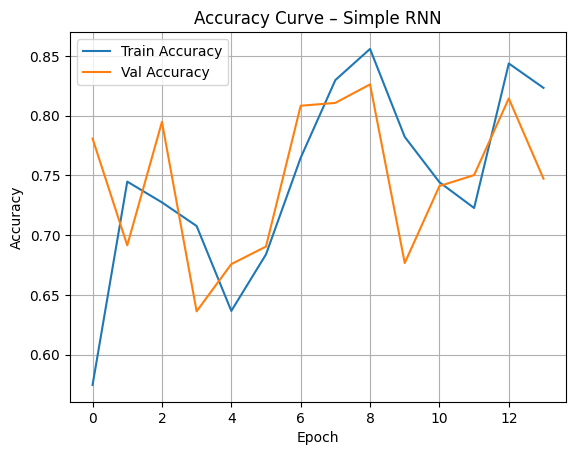

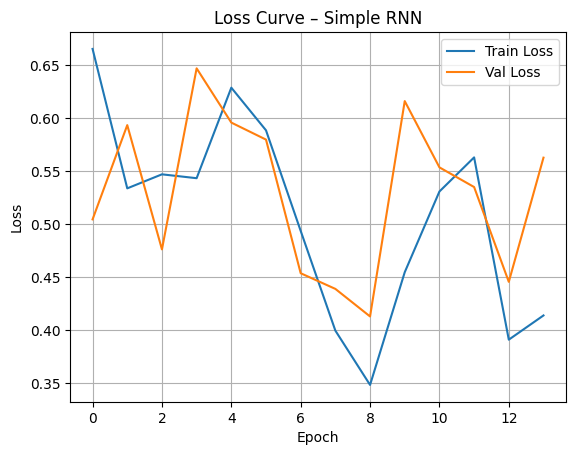

In [ ]:
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve – Simple RNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Val Loss')
plt.title('Loss Curve – Simple RNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Confusion Matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step


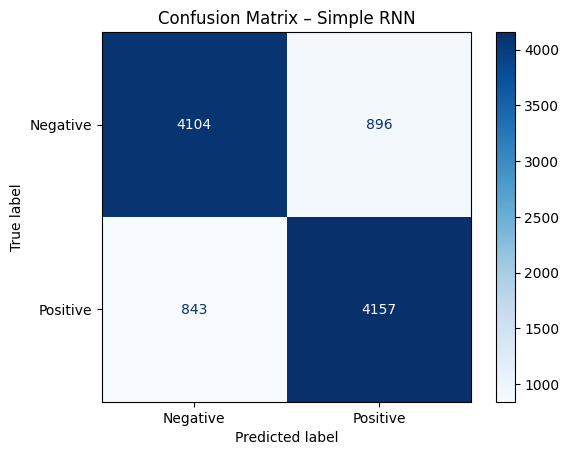

In [ ]:
y_pred_prob = model_rnn.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix – Simple RNN")
plt.show()

# Classification Report

In [ ]:
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.83      0.82      0.83      5000
    Positive       0.82      0.83      0.83      5000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



# Qualitative Analysis

High-Confidence Correct Predictions

In [ ]:
y_pred_prob = model_rnn.predict(X_test_pad).flatten()
y_pred = (y_pred_prob > 0.5).astype("int32")


correct_mask = (y_pred == y_test)
correct_probs = y_pred_prob[correct_mask]
correct_texts = X_test_texts[correct_mask]
correct_labels = y_test[correct_mask]


top_correct_indices = np.argsort(correct_probs)[-5:][::-1]


print(" Top High-Confidence Correct Predictions:\n")
for i in top_correct_indices:
    print(" Review:")
    print(correct_texts[i][:500])
    print(f"Actual Label: {correct_labels[i]}, Predicted Prob: {correct_probs[i]:.4f}")
    print("-" * 60)

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step
 Top High-Confidence Correct Predictions:

 Review:
excellent blend music light comedy and drama with picture perfect performance peter and and romantic supporting performance clark able show the shy teacher that wish much love his student and only able express his love when marry clark she bring him the world what lot flower and forever change become the beloved through tragedy but know could only have achieve his goal through love the song with the exception the music hall number be all thought song come from character emotion and thought and t
Actual Label: 1, Predicted Prob: 0.9768
------------------------------------------------------------
 Review:
excellent comedy star dudley moore support minnelli and good speaking john gielgud moore arthur man family who be near get million dollar provide that marries lady susan from another family principle arthur accept the condition but finally refuse when meet nice and poor linda arthur be just be

low-Confidence  Predictions

In [ ]:
wrong_preds = (y_test != y_pred.flatten())
wrong_reviews = X_test_texts[wrong_preds]

for i in range(3):
    print(" Review:")
    print(wrong_reviews[i])
    print(f"Actual: {y_test[wrong_preds][i]}, Predicted: {y_pred[wrong_preds][i]}")
    print("-" * 60)


 Review:
have be pleasantly surprised sandra performance miss decide give murder number shoot while decent self role performance serious role see hope speed day leave much desire her character the same time confuse and sexually the sub plot past come across needless filler that do little develop her already shallow character the two teenage boy give decent performance although their expertise and catch can attitude stupid error that scream do chris penn the all too obvious suspect waste here ben token partner love interest character spoiler ahead mediocre act aside the big flaw can the week plot that never have you totally buy into the murder motives the first place and mention the stupid error rare food the murder scene all too convenient and frame the school janitor the two boy hang out together public convenient love interest cause etc etc cause the view from be be bore and disappoint the murderer the end be strictly the number and be probably the most disappointing aspect the movie

____________________________________________________________________________________________________________________________________________________________________


#  Long Short-Term Memory -LSTM-

____________________________________________________________________________________________________________________________________________________________________


In [ ]:
model_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=300),
    LSTM(units=64, return_sequences=False),
    Dropout(0.4),
    Dense(32),
    LeakyReLU(alpha=0.01),
    Dense(1, activation='sigmoid')
])


model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=60,
    batch_size=128,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)


Epoch 1/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 179s 559ms/step - accuracy: 0.4989 - loss: 0.6934 - val_accuracy: 0.5157 - val_loss: 0.6925
Epoch 2/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 148s 472ms/step - accuracy: 0.5175 - loss: 0.6891 - val_accuracy: 0.5302 - val_loss: 0.6787
Epoch 3/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 213s 507ms/step - accuracy: 0.5328 - loss: 0.6706 - val_accuracy: 0.5307 - val_loss: 0.6781
Epoch 4/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 159s 508ms/step - accuracy: 0.5523 - loss: 0.6437 - val_accuracy: 0.5346 - val_loss: 0.6860
Epoch 5/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 158s 505ms/step - accuracy: 0.5540 - loss: 0.6307 - val_accuracy: 0.5335 - val_loss: 0.6971
Epoch 6/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 158s 506ms/step - accuracy: 0.5516 - loss: 0.6223 - val_accuracy: 0.5312 - val_loss: 0.7129
Epoch 7/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 206s 517ms/step - accuracy: 0.5640 - loss: 0.6188 - val_accuracy: 0.5615 - val_loss: 0.7439
Epoch 8/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 152s 486ms/step - accuracy: 0.7440 -

# Evaluation of LSTM Model

In [ ]:
y_pred_prob = model_lstm.predict(X_test_pad).flatten()
y_pred = (y_pred_prob > 0.5).astype("int32")

print(f" Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f" Precision: {precision_score(y_test, y_pred):.4f}")
print(f" Recall:    {recall_score(y_test, y_pred):.4f}")
print(f" F1 Score:  {f1_score(y_test, y_pred):.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step
 Accuracy:  0.8804
 Precision: 0.8737
 Recall:    0.8894
 F1 Score:  0.8815
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step
 Accuracy:  0.8804
 Precision: 0.8737
 Recall:    0.8894
 F1 Score:  0.8815


Plot Training & Validation Accuracy

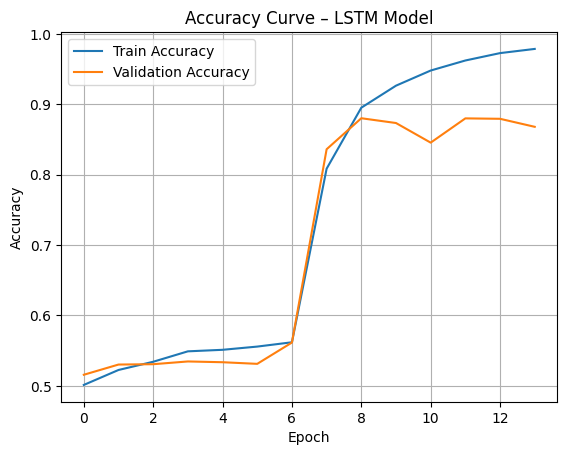

In [ ]:
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve – LSTM Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training & Validation Loss

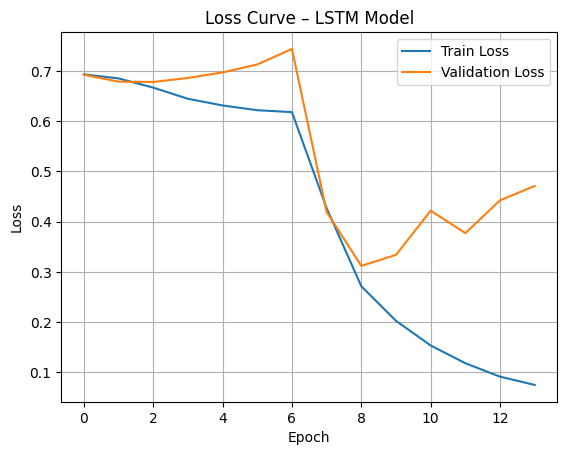

In [ ]:
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve – LSTM Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Confusion Matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step


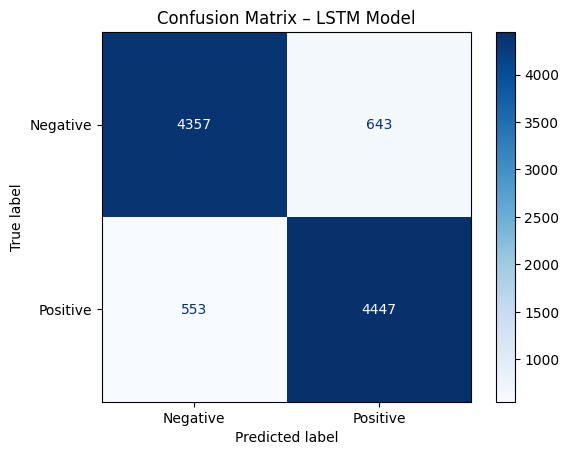

In [ ]:
y_pred_prob = model_lstm.predict(X_test_pad).flatten()
y_pred = (y_pred_prob > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix – LSTM Model")
plt.show()


# Classification Report

In [ ]:
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.89      0.87      0.88      5000
    Positive       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



# High-Confidence Wrong Predictions (Qualitative Error Analysis)

In [ ]:
wrong_mask = (y_pred != y_test)
wrong_conf = y_pred_prob[wrong_mask]
wrong_texts = X_test_texts[wrong_mask]

top_wrong = np.argsort(wrong_conf)[-3:][::-1]

print(" High-Confidence Wrong Predictions:\n")
for i in top_wrong:
    print("Review:")
    print(wrong_texts[i][:500]) # Use array indexing instead of .iloc
    print(f"Actual: {y_test[wrong_mask][i]}, Predicted Prob: {wrong_conf[i]:.4f}") # Use array indexing instead of .iloc
    print("-" * 60)


 High-Confidence Wrong Predictions:

Review:
firmly believe that the best oscar ceremony recent year be for two reason host steve martin be his most saw the help michael moore into the his and good not mention the gay mafia case wake with head bed surprise winner one have down for best actor genuine applause roman polanski for best director genuine and but they win last year award ceremony wasn too bad but there be little the way surprise and be happy see return the king the award even wasn the best the trilogy be much good but what let th
Actual: 0, Predicted Prob: 1.0000
------------------------------------------------------------
Review:
the story go something like this small town girl katie jessica simpson decide visit her boyfriend the big city when she arrive she discover isn quite faithful should katie then end into the adventure that new york filling bike comedic and charm ensues she fall into hole the ground and thus meet charismatic good guy ben luke wilson not love first sig

High-Confidence Correct Predictions

In [ ]:
correct_mask = (y_pred == y_test)
correct_conf = y_pred_prob[correct_mask]
correct_texts = X_test_texts[correct_mask]

top_correct = np.argsort(correct_conf)[-3:][::-1]

print("High-Confidence Correct Predictions:\n")
for i in top_correct:
    print("Review:")
    print(correct_texts[i][:500]) # Access using array indexing
    print(f"Actual: {y_test[correct_mask][i]}, Predicted Prob: {correct_conf[i]:.4f}")  # Access using array indexing
    print("-" * 60)


High-Confidence Correct Predictions:

Review:
the notorious bettie page gretchen mol taylor chris bauer jar harris sarah david austin norman dallas robert mol shine legendary pin queen bettie page fine biopic gretchen mol probably best know for be the next girl few year ago when one knew who she be despite infamous cover story vanity fair among other medium but despite few star role here and there her predicted stardom seem less until now here the famous pin queen bettie page gretchen mol indeed shin star the rise bettie page be bear raise 
Actual: 1, Predicted Prob: 1.0000
------------------------------------------------------------
Review:
one reason pixar have endure well and be successful that while their film remain technical and visual they have story match their style and often very move style that affect charming and cross that lot anime speak broad term and great many other animation fail match their technical with real substance think and might wrong partly because either the

____________________________________________________________________________________________________________________________________________________________________


# GRU Model

____________________________________________________________________________________________________________________________________________________________________


In [ ]:
model_gru = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=300),
    GRU(units=64, return_sequences=False),
    Dropout(0.4),
    Dense(32),
    LeakyReLU(alpha=0.01),
    Dense(1, activation='sigmoid')
])

model_gru.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_gru = model_gru.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=60,
    batch_size=128,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 234s 723ms/step - accuracy: 0.5057 - loss: 0.6932 - val_accuracy: 0.5096 - val_loss: 0.6926
Epoch 2/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 235s 639ms/step - accuracy: 0.5080 - loss: 0.6902 - val_accuracy: 0.5089 - val_loss: 0.6928
Epoch 3/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 209s 668ms/step - accuracy: 0.5378 - loss: 0.6738 - val_accuracy: 0.5932 - val_loss: 0.6739
Epoch 4/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 253s 639ms/step - accuracy: 0.7692 - loss: 0.4826 - val_accuracy: 0.8757 - val_loss: 0.3083
Epoch 5/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 205s 654ms/step - accuracy: 0.9101 - loss: 0.2487 - val_accuracy: 0.8983 - val_loss: 0.2656
Epoch 6/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 260s 649ms/step - accuracy: 0.9380 - loss: 0.1819 - val_accuracy: 0.8946 - val_loss: 0.2794
Epoch 7/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 203s 648ms/step - accuracy: 0.9553 - loss: 0.1356 - val_accuracy: 0.8928 - val_loss: 0.3074
Epoch 8/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 261s 647ms/step - accuracy: 0.9681 -

Generate Predictions

In [ ]:
y_pred_prob = model_gru.predict(X_test_pad).flatten()
y_pred = (y_pred_prob > 0.5).astype("int32")

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step


In [ ]:
print(f" Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f" Precision: {precision_score(y_test, y_pred):.4f}")
print(f" Recall:    {recall_score(y_test, y_pred):.4f}")
print(f" F1 Score:  {f1_score(y_test, y_pred):.4f}")


 Accuracy:  0.8983
 Precision: 0.8955
 Recall:    0.9018
 F1 Score:  0.8987


Plot Confusion Matrix

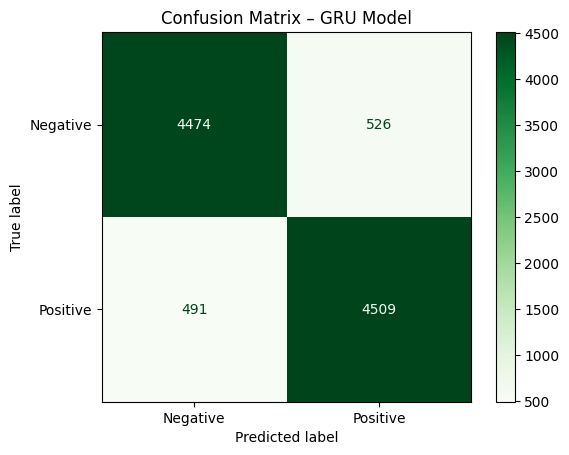

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Greens')
plt.title("Confusion Matrix – GRU Model")
plt.show()

Accuracy Curve




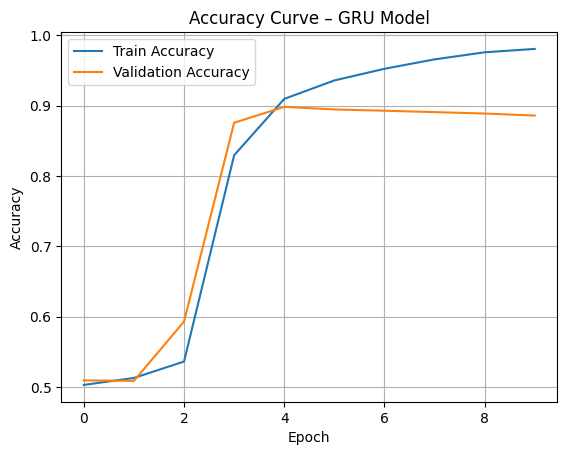

In [ ]:
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve – GRU Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Loss Curve

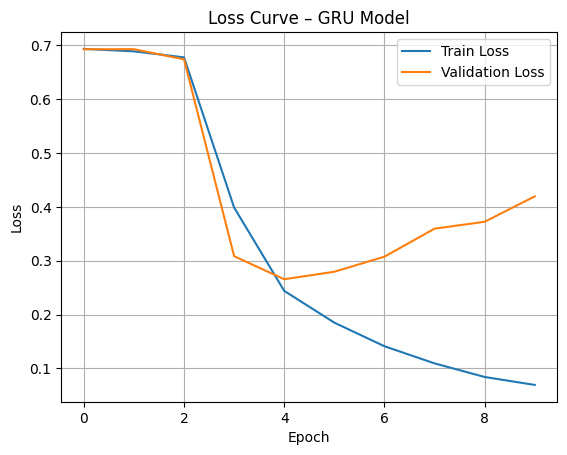

In [ ]:
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve – GRU Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

____________________________________________________________________________________________________________________________________________________________________


# Compare All Models: Accuracy & Loss Curves


____________________________________________________________________________________________________________________________________________________________________


Accuracy Comparison Plot

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history_rnn.history['val_accuracy'], label='RNN – Validation Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM – Validation Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='GRU – Validation Accuracy')

plt.title(' Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'history_rnn' is not defined

<Figure size 1000x600 with 0 Axes>

Loss Comparison Plot

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(history_rnn.history['val_loss'], label='RNN – Validation Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM – Validation Loss')
plt.plot(history_gru.history['val_loss'], label='GRU – Validation Loss')

plt.title('📉 Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# models save

In [ ]:
model_gru.save("gru_model.h5")
model_lstm.save("lstm_model.h5")
model_rnn.save("rnn_model.h5")


____________________________________________________________________________________________________________________________________________________________________


# Hyperparameter Optimization

After evaluating all models, GRU achieved the highest validation performance with efficient training time. Therefore, it was selected for hyperparameter optimization using Optuna to further maximize its accuracy and generalization.


____________________________________________________________________________________________________________________________________________________________________


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.6 MB/s eta 0:00:00


In [ ]:
def objective(trial):
    model = Sequential()


    embedding_dim = trial.suggest_categorical('embedding_dim', [32, 64, 128])
    model.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=300))


    gru_units = trial.suggest_int('gru_units', 32, 128, step=32)
    model.add(GRU(units=gru_units, return_sequences=False))


    dropout_rate = trial.suggest_float('dropout', 0.2, 0.5, step=0.1)
    model.add(Dropout(rate=dropout_rate))


    model.add(Dense(1, activation='sigmoid'))


    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )


    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_test_pad, y_test),
        epochs=5,
        batch_size=batch_size,
        verbose=0
    )


    val_accuracy = history.history["val_accuracy"][-1]
    return val_accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)


[I 2025-04-18 13:34:34,230] A new study created in memory with name: no-name-b8384b3a-be06-4ab8-ae29-01f6deafb065
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2025-04-18 13:35:18,884] Trial 0 finished with value: 0.8898000121116638 and parameters: {'embedding_dim': 64, 'gru_units': 64, 'dropout': 0.5, 'lr': 0.004295901309051497, 'batch_size': 64}. Best is trial 0 with value: 0.8898000121116638.
[I 2025-04-18 13:35:40,368] Trial 1 finished with value: 0.890500009059906 and parameters: {'embedding_dim': 32, 'gru_units': 32, 'dropout': 0.2, 'lr': 0.004908765718761995, 'batch_size': 128}. Best is trial 1 with value: 0.890500009059906.
[I 2025-04-18 13:36:22,636] Trial 2 finished with value: 0.6812999844551086 and parameters: {'embedding_dim': 32, 'gru_units': 96, 'dropout': 0.2, 'lr': 0.00012581383123312444, 'batch_size': 64}. Best is trial 1 with value: 0.8905000090599

In [ ]:
print(" Best Hyperparameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

print(f"\n Best Validation Accuracy: {study.best_value:.4f}")


 Best Hyperparameters:
embedding_dim: 32
gru_units: 32
dropout: 0.5
lr: 0.002925248561355503
batch_size: 64

 Best Validation Accuracy: 0.8947


Hyperparameter optimization was conducted using Optuna with a search space over embedding_dim, gru_units, dropout, batch_size, and learning_rate. The best configuration achieved a validation accuracy of {study.best_value:.4f}.

After automated hyperparameter tuning using Optuna, we rebuilt the GRU model using the best configuration and trained it for 10 full epochs. This yielded the final optimized performance reported."

# Hyperparameter Optimization on GRU Model

In [ ]:

model_gru_opt = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=300),
    GRU(units=32, return_sequences=False),
    Dropout(0.5),
    Dense(32),
    LeakyReLU(alpha=0.01),
    Dense(1, activation='sigmoid')
])


optimizer = Adam(learning_rate=0.00293)

model_gru_opt.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


history_gru_opt = model_gru_opt.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=60,
    batch_size=64,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)


Epoch 1/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4992 - loss: 0.6937 - val_accuracy: 0.5076 - val_loss: 0.6927
Epoch 2/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5103 - loss: 0.6916 - val_accuracy: 0.6861 - val_loss: 0.6655
Epoch 3/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8040 - loss: 0.4379 - val_accuracy: 0.8974 - val_loss: 0.2544
Epoch 4/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9206 - loss: 0.2159 - val_accuracy: 0.8963 - val_loss: 0.2685
Epoch 5/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9465 - loss: 0.1572 - val_accuracy: 0.8861 - val_loss: 0.3392
Epoch 6/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9628 - loss: 0.1140 - val_accuracy: 0.8769 - val_loss: 0.4092
Epoch 7/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9705 - loss: 0.0952 - val_accuracy: 0.8835 - val_loss: 0.4368
Epoch 8/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9795 - loss: 0.0633 - val_acc

In [ ]:
y_pred_prob = model_gru_opt.predict(X_test_pad).flatten()
y_pred = (y_pred_prob > 0.5).astype("int32")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [ ]:
print(f" Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f" Precision: {precision_score(y_test, y_pred):.4f}")
print(f" Recall:    {recall_score(y_test, y_pred):.4f}")
print(f" F1 Score:  {f1_score(y_test, y_pred):.4f}")


 Accuracy:  0.8711
 Precision: 0.8425
 Recall:    0.9128
 F1 Score:  0.8763


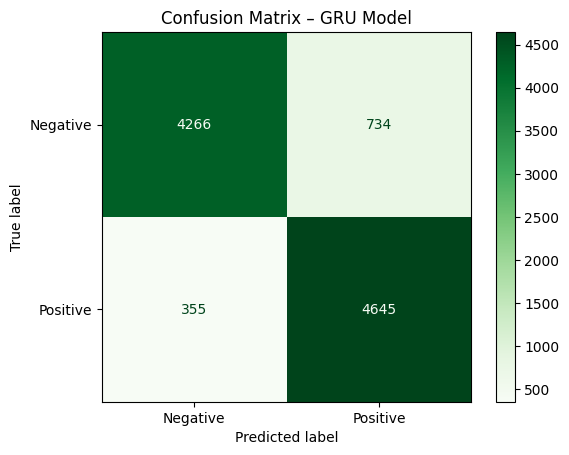

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Greens')
plt.title("Confusion Matrix – GRU Model")
plt.show()

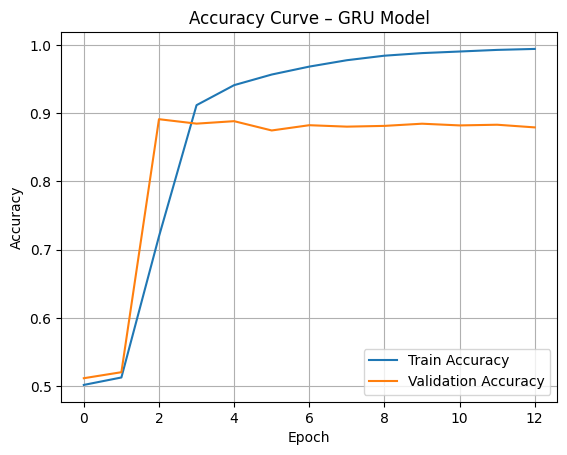

In [ ]:
plt.plot(history_gru_opt.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru_opt.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve – GRU Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

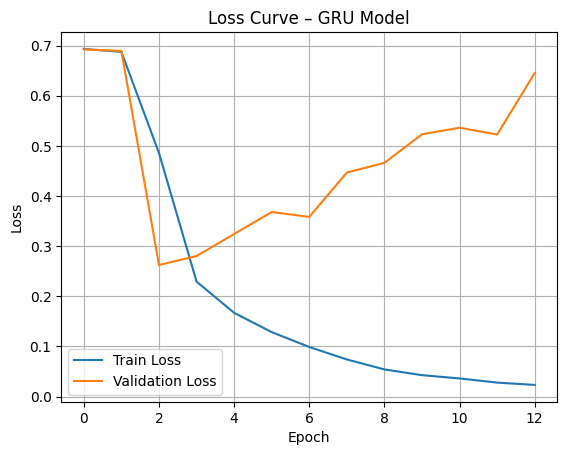

In [ ]:
plt.plot(history_gru_opt.history['loss'], label='Train Loss')
plt.plot(history_gru_opt.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve – GRU Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Bidirectional GRU

In [ ]:
model_bi_gru = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=300),
    Bidirectional(GRU(units=32, return_sequences=False)),
    Dropout(0.5),
    Dense(32),
    LeakyReLU(alpha=0.01),
    Dense(1, activation='sigmoid')
])


optimizer = Adam(learning_rate=0.00293)


model_bi_gru.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


history_bi_gru = model_bi_gru.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=60,
    batch_size=64,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)


Epoch 1/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.6878 - loss: 0.5650 - val_accuracy: 0.8814 - val_loss: 0.2985
Epoch 2/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8866 - loss: 0.2828 - val_accuracy: 0.8954 - val_loss: 0.2601
Epoch 3/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9225 - loss: 0.2070 - val_accuracy: 0.8880 - val_loss: 0.2819
Epoch 4/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9452 - loss: 0.1532 - val_accuracy: 0.8881 - val_loss: 0.3248
Epoch 5/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9592 - loss: 0.1188 - val_accuracy: 0.8736 - val_loss: 0.4075
Epoch 6/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9705 - loss: 0.0896 - val_accuracy: 0.8725 - val_loss: 0.4839
Epoch 7/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9731 - loss: 0.0805 - val_accuracy: 0.8844 - val_loss: 0.4666


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_prob = model_bi_gru.predict(X_test_pad).flatten()
y_pred = (y_pred_prob > 0.5).astype("int32")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


In [ ]:
print(f" Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f" Precision: {precision_score(y_test, y_pred):.4f}")
print(f" Recall:    {recall_score(y_test, y_pred):.4f}")
print(f" F1 Score:  {f1_score(y_test, y_pred):.4f}")

 Accuracy:  0.8954
 Precision: 0.8965
 Recall:    0.8940
 F1 Score:  0.8953


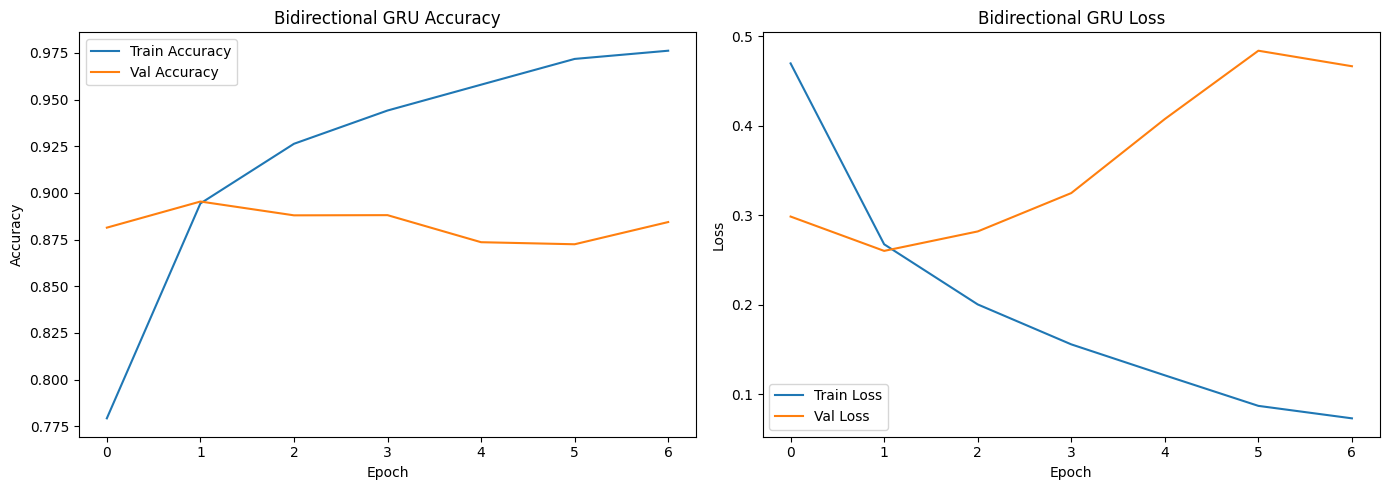

In [ ]:
def plot_training_history(history, model_name="Model"):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_history(history_bi_gru, model_name="Bidirectional GRU")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.8943    0.8968    0.8955      5000
           1     0.8965    0.8940    0.8953      5000

    accuracy                         0.8954     10000
   macro avg     0.8954    0.8954    0.8954     10000
weighted avg     0.8954    0.8954    0.8954     10000



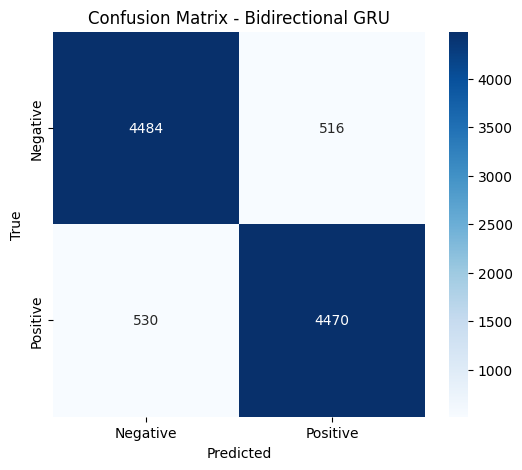

In [ ]:
y_pred_prob = model_bi_gru.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Bidirectional GRU')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Bidirectional LSTM

In [ ]:
model_bi_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=300),
    Bidirectional(LSTM(units=32, return_sequences=False)),
    Dropout(0.5),
    Dense(32),
    LeakyReLU(alpha=0.01),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.00293)


model_bi_lstm.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


history_bi_lstm = model_bi_lstm.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=60,
    batch_size=64,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.6776 - loss: 0.5842 - val_accuracy: 0.8707 - val_loss: 0.3151
Epoch 2/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8746 - loss: 0.3243 - val_accuracy: 0.8741 - val_loss: 0.3037
Epoch 3/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8830 - loss: 0.3096 - val_accuracy: 0.8822 - val_loss: 0.2984
Epoch 4/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9160 - loss: 0.2281 - val_accuracy: 0.8771 - val_loss: 0.3058
Epoch 5/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8935 - loss: 0.2695 - val_accuracy: 0.8732 - val_loss: 0.3292
Epoch 6/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9229 - loss: 0.2083 - val_accuracy: 0.8802 - val_loss: 0.3353
Epoch 7/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9425 - loss: 0.1687 - val_accuracy: 0.8784 - val_loss: 0.3402
Epoch 8/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.9503 - loss: 0.1458 - val_accurac

In [ ]:
y_pred_prob = model_bi_lstm.predict(X_test_pad).flatten()
y_pred = (y_pred_prob > 0.5).astype("int32")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


In [ ]:
print(f" Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f" Precision: {precision_score(y_test, y_pred):.4f}")
print(f" Recall:    {recall_score(y_test, y_pred):.4f}")
print(f" F1 Score:  {f1_score(y_test, y_pred):.4f}")

 Accuracy:  0.8822
 Precision: 0.8612
 Recall:    0.9112
 F1 Score:  0.8855


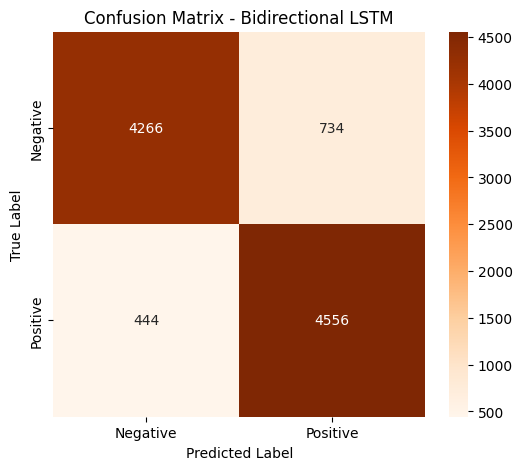

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Bidirectional LSTM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

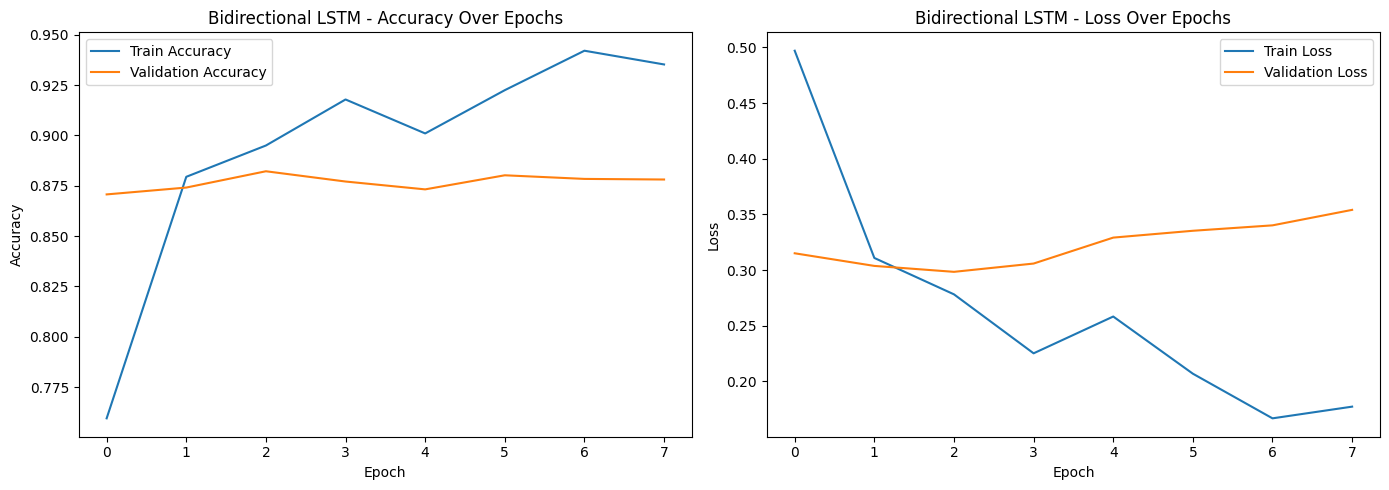

In [ ]:
def plot_accuracy_loss(history, model_name="Model"):
    plt.figure(figsize=(14, 5))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_accuracy_loss(history_bi_lstm, model_name="Bidirectional LSTM")
